In [95]:
import os 

import efficient_kan
from efficient_kan import KAN, KANLinear
import torch

from torch import nn
from torch import optim
from torch.functional import F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from chebykanlayer import ChebyKANLayer
from fourierkanlayer import NaiveFourierKANLayer
from helper_functions import *

from sklearn.model_selection import train_test_split


import pandas as pd

In [40]:
os.getcwd()


'c:\\Users\\jako\\ml_playground\\torch_models'

In [96]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [86]:
def generate_multimodal_data(n_samples=1000):
    # Generate input features
    X = np.random.rand(n_samples, 2) * 10 - 5  # Uniformly distributed between -5 and 5

    # Generate outputs
    Y = np.zeros((n_samples, 2))

    for i in range(n_samples):
        x1, x2 = X[i]
        
        # Output 1: Multi-modal based on quadratic function and sine wave
        if np.random.rand() > 0.5:
            Y[i, 0] = 0.5 * (x1**2 - x2**2) + np.random.normal(0, 0.5)
        else:
            Y[i, 0] = 2 * np.sin(x1) + np.cos(x2) + np.random.normal(0, 0.5)

        # Output 2: Multi-modal based on circular function and exponential
        r = np.sqrt(x1**2 + x2**2)
        if r < 2.5:
            Y[i, 1] = np.sin(r) + np.random.normal(0, 0.2)
        else:
            Y[i, 1] = 0.1 * np.exp(0.5 * r) + np.random.normal(0, 0.5)

    return X, Y

# Generate the data
X, Y = generate_multimodal_data(5000)

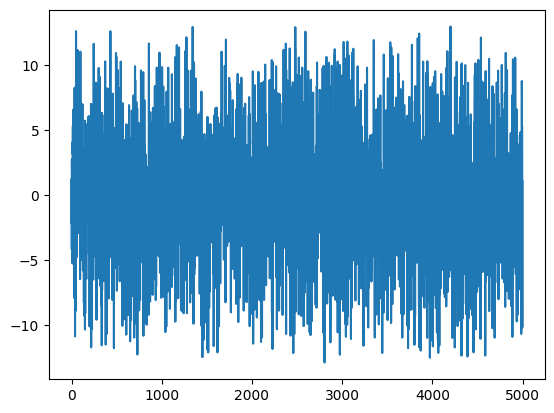

In [93]:
plt.plot(Y[:, 0])


In [94]:
class MixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_mixtures, n_hidden_layers=2):
        super().__init__()

        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        self.hidden_block = nn.Sequential(*layers)

        # Output layers
        self.pi = nn.Linear(hidden_dim, n_mixtures)
        self.mu = nn.Linear(hidden_dim, n_mixtures * output_dim)
        self.sigma = nn.Linear(hidden_dim, n_mixtures * output_dim)
        
        self.n_mixtures = n_mixtures
        self.output_dim = output_dim

    def forward(self, x):
        hidden = self.hidden_block(x)
        
        pi = F.softmax(self.pi(hidden), dim=1)
        mu = self.mu(hidden)
        sigma = torch.exp(self.sigma(hidden))
        
        if self.output_dim > 1:
            mu = mu.view(-1, self.n_mixtures, self.output_dim)
            sigma = sigma.view(-1, self.n_mixtures, self.output_dim)
        
        return pi, mu, sigma

In [122]:
# Convert to PyTorch tensors and split into train/test sets
X_tensor = torch.FloatTensor(X)
Y_tensor = torch.FloatTensor(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

In [105]:
# Define hyperparameters
input_dim = 2
hidden_dim = 64
output_dim = 2
n_mixtures = 5
n_hidden_layers = 2
learning_rate = 0.001
n_epochs = 1000
batch_size = 64

In [109]:
# Corrected loss function
def mdn_loss_multi(pi, mu, sigma, y):
    # Ensure y has the right shape
    y = y.unsqueeze(1).expand_as(mu)
    
    # Compute the normal distribution
    normal = torch.distributions.Normal(mu, sigma)
    
    # Compute log probability
    log_prob = normal.log_prob(y).sum(dim=2)
    
    # Compute the mixture log probability
    weighted_logprob = log_prob + torch.log(pi + 1e-8)
    
    # Compute the final loss
    loss = -torch.logsumexp(weighted_logprob, dim=1)
    
    return loss.mean()

In [110]:
# Initialize the model
mdn = MixtureDensityNetwork(input_dim, hidden_dim, output_dim, n_mixtures, n_hidden_layers)
mdn.to(device)
optimizer = optim.Adam(mdn.parameters(), lr=learning_rate)

In [111]:
# Training loop
losses = []
for epoch in range(n_epochs):
    mdn.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_Y = Y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        pi, mu, sigma = mdn(batch_X)
        loss = mdn_loss_multi(pi, mu, sigma, batch_Y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / (len(X_train) / batch_size)
    losses.append(avg_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

Epoch 0, Loss: 4.1898
Epoch 100, Loss: 1.8979
Epoch 200, Loss: 1.8222
Epoch 300, Loss: 1.8061
Epoch 400, Loss: 1.7916
Epoch 500, Loss: 1.7784
Epoch 600, Loss: 1.7659
Epoch 700, Loss: 1.7312
Epoch 800, Loss: 1.7213
Epoch 900, Loss: 1.7135


Text(0, 0.5, 'Loss')

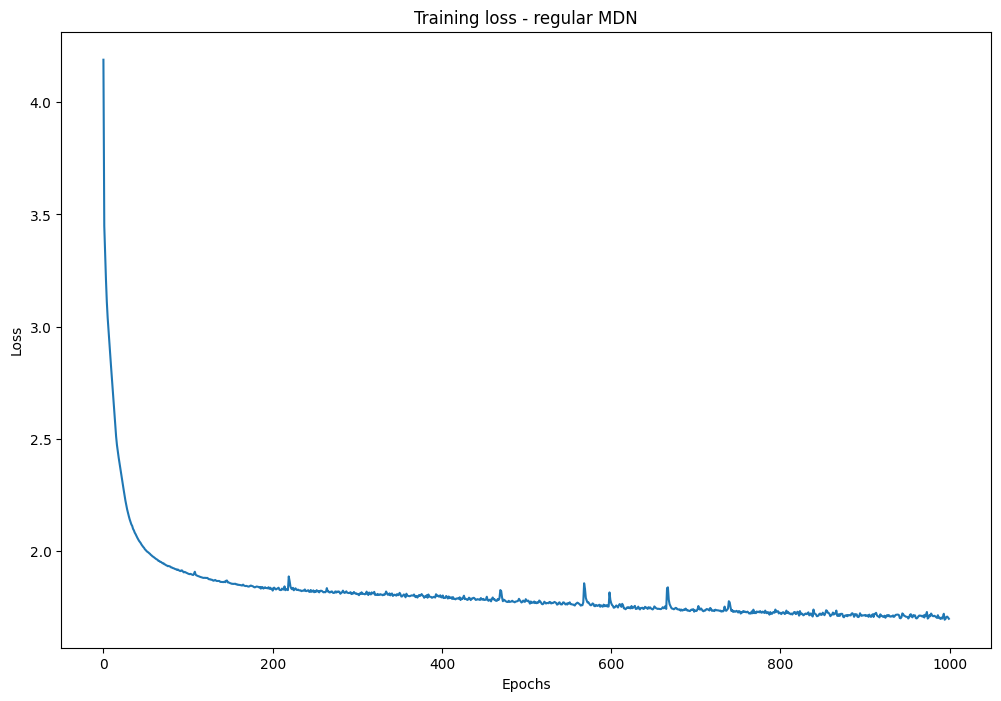

In [112]:
plt.figure(figsize=(12, 8))
plt.plot(losses)
plt.title("Training loss - regular MDN")
plt.xlabel("Epochs")
plt.ylabel("Loss")


In [115]:
# Evaluation
mdn.eval()
with torch.no_grad():
    pi, mu, sigma = mdn(X_test.to(device))
    test_loss = mdn_loss_multi(pi, mu, sigma, Y_test.to(device))
    print(f"Test Loss: {test_loss:.4f}")

Test Loss: 2.3360


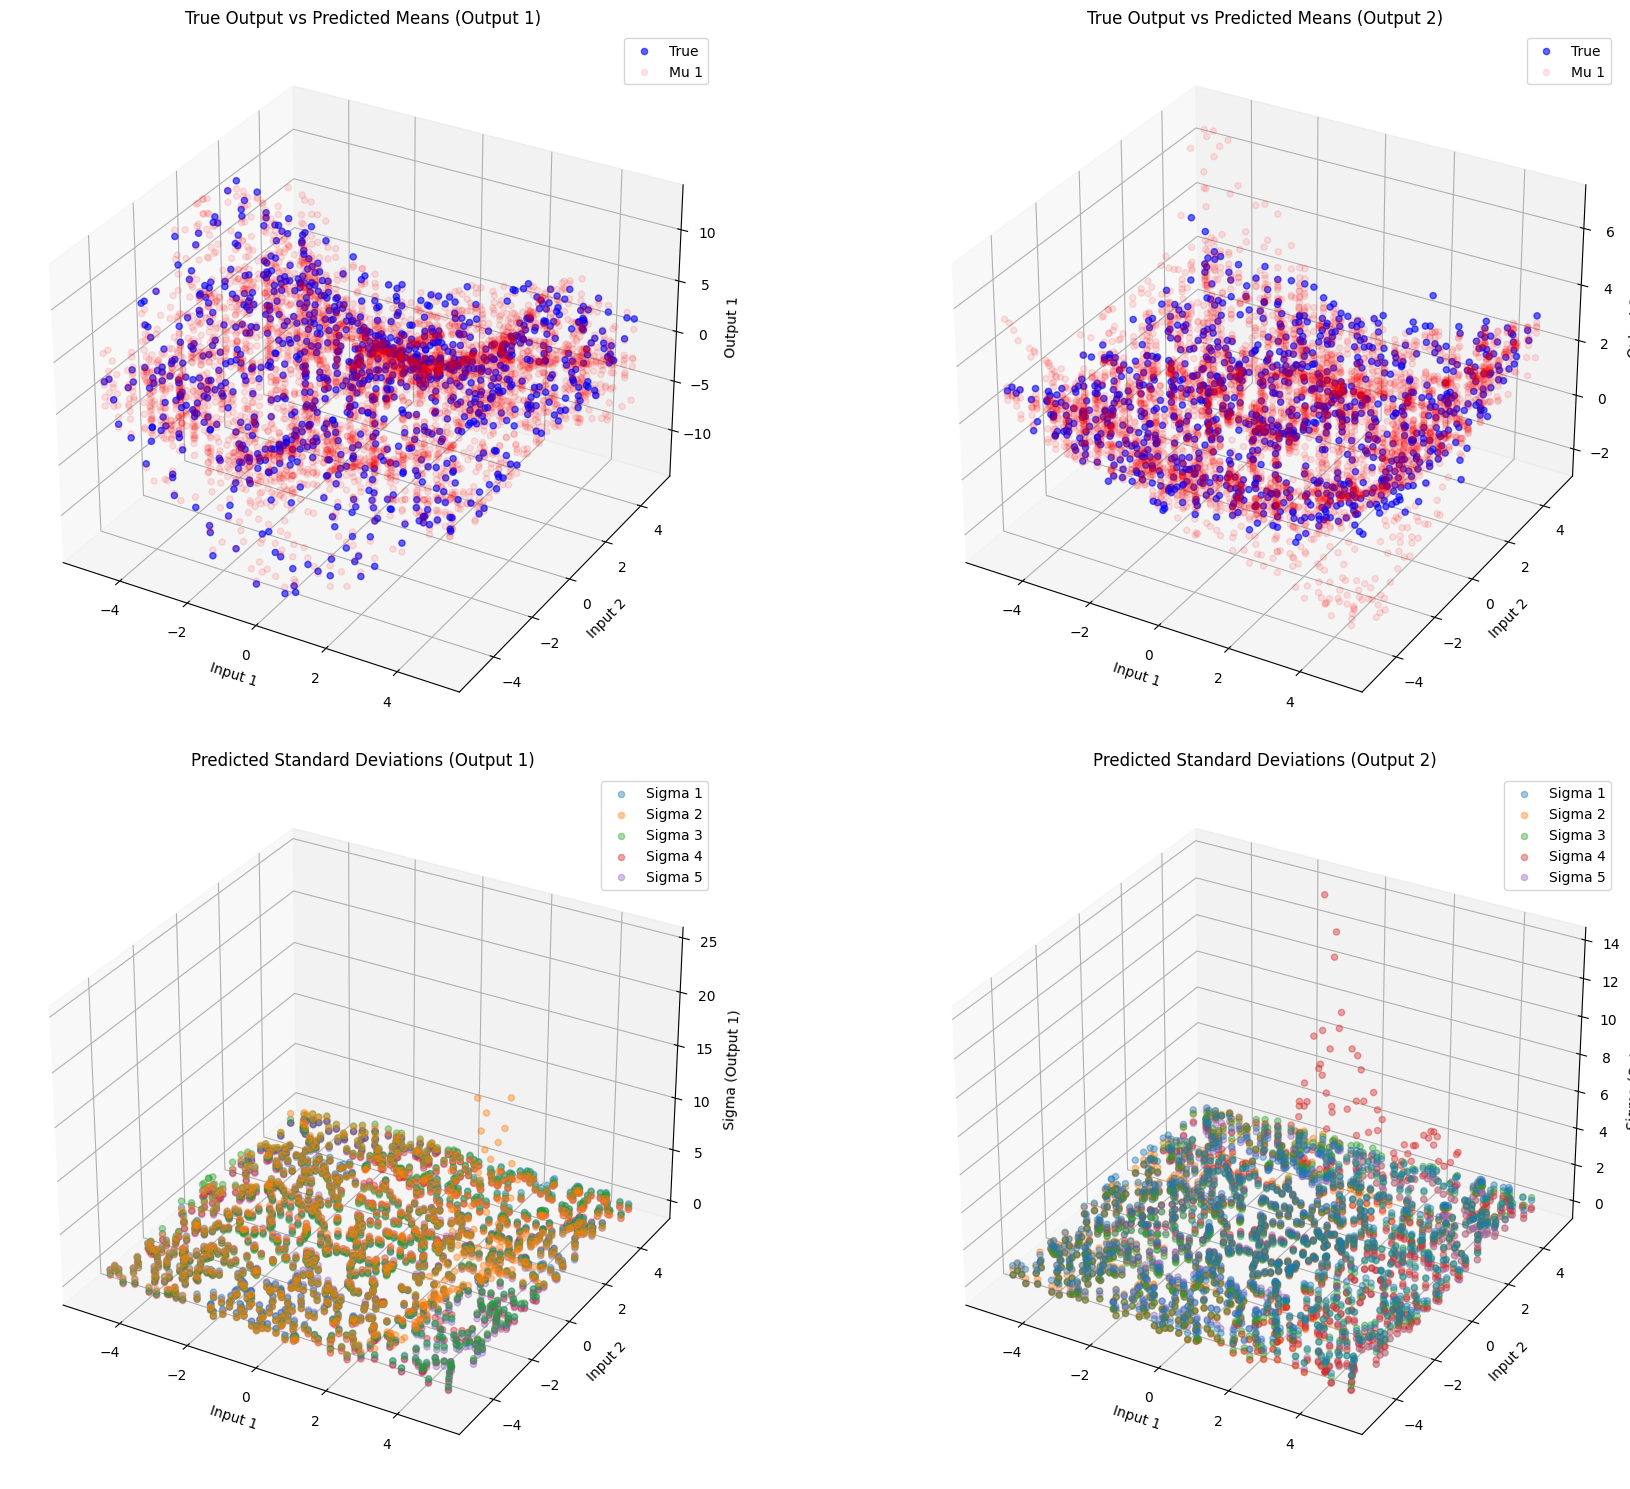

In [126]:
# Create 3D scatter plots
fig = plt.figure(figsize=(20, 15))

# X_train, Y_train, X_test, Y_test = X_train.detach().cpu().numpy(), Y_train.detach().cpu().numpy(), X_test.detach().cpu().numpy(), Y_test.detach().cpu().numpy()
pi, mu, sigma = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()

# Plot for the first output dimension
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(X_test[:, 0], X_test[:, 1], Y_test[:, 0], c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax1.scatter(X_test[:, 0], X_test[:, 1], mu[:, i, 0], c='r', alpha=0.1, label=f'Mu {i+1}' if i == 0 else "")
ax1.set_xlabel('Input 1')
ax1.set_ylabel('Input 2')
ax1.set_zlabel('Output 1')
ax1.set_title('True Output vs Predicted Means (Output 1)')
ax1.legend()

# Plot for the second output dimension
ax2 = fig.add_subplot(222, projection='3d')
scatter = ax2.scatter(X_test[:, 0], X_test[:, 1], Y_test[:, 1], c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax2.scatter(X_test[:, 0], X_test[:, 1], mu[:, i, 1], c='r', alpha=0.1, label=f'Mu {i+1}' if i == 0 else "")
ax2.set_xlabel('Input 1')
ax2.set_ylabel('Input 2')
ax2.set_zlabel('Output 2')
ax2.set_title('True Output vs Predicted Means (Output 2)')
ax2.legend()

# Plot sigmas for the first output dimension
ax3 = fig.add_subplot(223, projection='3d')
for i in range(sigma.shape[1]):  # For each mixture component
    ax3.scatter(X_test[:, 0], X_test[:, 1], sigma[:, i, 0], c=f'C{i}', alpha=0.4, label=f'Sigma {i+1}')
ax3.set_xlabel('Input 1')
ax3.set_ylabel('Input 2')
ax3.set_zlabel('Sigma (Output 1)')
ax3.set_title('Predicted Standard Deviations (Output 1)')
ax3.legend()

# Plot sigmas for the second output dimension
ax4 = fig.add_subplot(224, projection='3d')
for i in range(sigma.shape[1]):  # For each mixture component
    ax4.scatter(X_test[:, 0], X_test[:, 1], sigma[:, i, 1], c=f'C{i}', alpha=0.4, label=f'Sigma {i+1}')
ax4.set_xlabel('Input 1')
ax4.set_ylabel('Input 2')
ax4.set_zlabel('Sigma (Output 2)')
ax4.set_title('Predicted Standard Deviations (Output 2)')
ax4.legend()

plt.tight_layout()
plt.show()


In [169]:
weights = [.3, .7]

mixture = np.random.normal(loc=0, scale=1, size=1000)*weights[0] + np.random.normal(loc=20, scale=0.1, size=1000)*weights[1]

(array([ 19.,  31., 123., 163., 201., 213., 148.,  76.,  19.,   7.]),
 array([13.137924  , 13.32017092, 13.50241784, 13.68466475, 13.86691167,
        14.04915859, 14.23140551, 14.41365243, 14.59589935, 14.77814626,
        14.96039318]),
 <BarContainer object of 10 artists>)

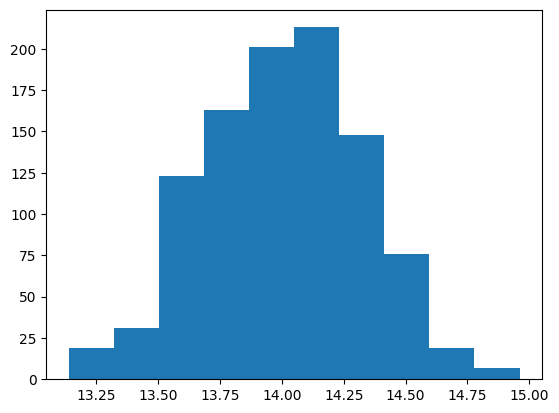

In [171]:
plt.hist(mixture)

In [405]:
mixtures = []
for i in range(1000):
    if np.random.multinomial(1, [.3, .4, .3])[0] == 1:
        mixtures.append( np.random.normal() )
    
    elif np.random.multinomial(1, [.3, .4, .3])[1] == 1:
        mixtures.append( np.random.poisson(10) )
    
    else:
        mixtures.append( np.random.gamma(2., 3.) )
    

c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

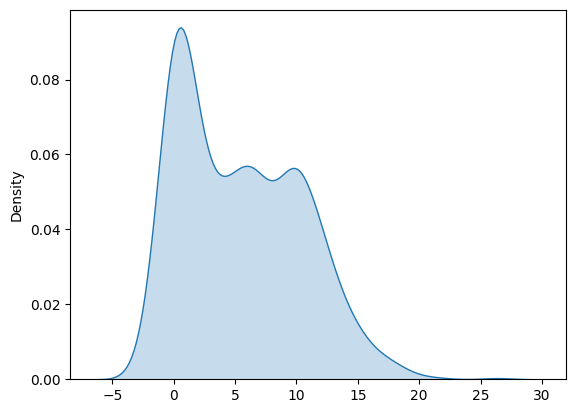

In [406]:
sns.kdeplot(mixtures, fill=True)

c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

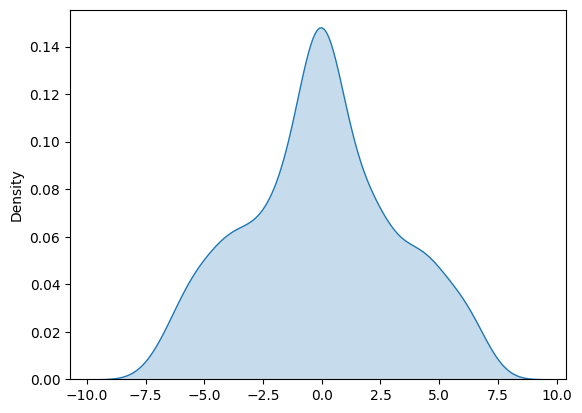

In [414]:
Xr = np.linspace(-10, 10, 1000)
y_mix = np.cos(mixtures)*Xr*.75

sns.kdeplot(y_mix, fill=True)

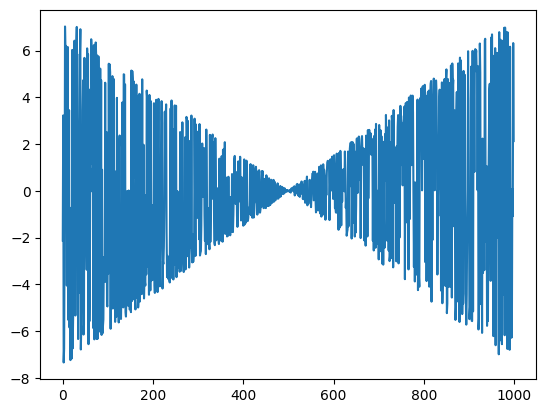

In [415]:
plt.plot(y_mix)

In [716]:
class mixdensnet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures):
        super().__init__()
        
        self.hidden_block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pi = nn.Linear(hidden_dim, n_mixtures)
        self.mu = nn.Linear(hidden_dim, n_mixtures)
        self.sigma = nn.Linear(hidden_dim, n_mixtures)
        
    def forward(self, x):
        # x = self.block(x)
        hidden = self.hidden_block(x)
        # Separate the output into mixture components
        pi, mu, sigma = F.softmax(self.pi(hidden), 1), self.mu(hidden), F.softplus(self.sigma(hidden))
        
        return pi, mu, sigma
    
class MixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_mixtures, n_hidden_layers=2):
        super().__init__()

        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        self.hidden_block = nn.Sequential(*layers)

        # Output layers
        self.pi = nn.Linear(hidden_dim, n_mixtures)
        self.mu = nn.Linear(hidden_dim, n_mixtures * output_dim)
        self.sigma = nn.Linear(hidden_dim, n_mixtures * output_dim)
        
        self.n_mixtures = n_mixtures
        self.output_dim = output_dim

    def forward(self, x):
        hidden = self.hidden_block(x)
        
        pi = F.softmax(self.pi(hidden), dim=1)
        mu = self.mu(hidden)
        sigma = torch.exp(self.sigma(hidden))
        
        if self.output_dim > 1:
            mu = mu.view(-1, self.n_mixtures, self.output_dim)
            sigma = sigma.view(-1, self.n_mixtures, self.output_dim)
        
        return pi, mu, sigma

In [443]:
X = torch.Tensor(Xr).to(device).type(torch.float).reshape(-1, 1)
Y = torch.Tensor(y_mix).to(device).type(torch.float).reshape(-1, 1)

(10000, 2)

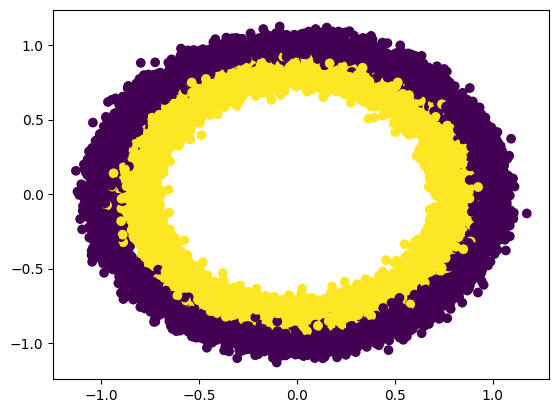

In [656]:
from sklearn.datasets import make_circles

x_circle, y_circle = make_circles(n_samples=10000, noise=.05)

plt.scatter(x_circle[:,0], x_circle[:, 1], c=y_circle)

x_circle.shape

In [732]:
# Initialize the model
mdn = MixtureDensityNetwork(2, 30, 1, 3)
mdn.to(device)
optimizer = optim.Adam(mdn.parameters(), lr=learning_rate, weight_decay=1e-5)

In [733]:
def mdn_loss_robust_univariate(y, mu, sigma, pi) -> torch.Tensor:
    # Ensure inputs are the correct shape
    y = y.unsqueeze(1).expand_as(mu)  # Shape: (batch_size, 1)
    
    # Numerical stability measures
    sigma = torch.clamp(sigma, min=1e-6, max=1e6)
    mu = torch.clamp(mu, min=-1e6, max=1e6)
    pi = torch.clamp(pi, min=1e-8)

    # Manual calculation of log probability
    z = (y - mu) / sigma
    log_p = -0.5 * (z**2) - torch.log(sigma) - 0.5 * np.log(2 * np.pi)

    # Compute log of weighted probabilities
    log_weighted_probs = torch.log(pi) + log_p

    # Use logsumexp for numerical stability
    max_log_probs = torch.max(log_weighted_probs, dim=1, keepdim=True)[0]
    log_weighted_sum = max_log_probs + torch.log(torch.sum(
        torch.exp(log_weighted_probs - max_log_probs), dim=1, keepdim=True))

    # Compute negative log likelihood
    loss = -log_weighted_sum.squeeze()

    return loss.mean()



def mdn_loss_3_components(pi, mu, sigma, y):
    """
    Compute the loss for a Mixture Density Network with 3 components.
    
    Args:
    - pi: tensor of shape [batch_size, 3] - mixture weights
    - mu: tensor of shape [batch_size, 3] - means of the Gaussians
    - sigma: tensor of shape [batch_size, 3] - standard deviations of the Gaussians
    - y: tensor of shape [batch_size, 1] - true target values
    
    Returns:
    - loss: scalar tensor - the mean negative log-likelihood
    """
    # Ensure numerical stability
    epsilon = 1e-6
    
    # Clip sigma to avoid division by zero
    sigma = torch.clamp(sigma, min=epsilon)
    
    # Expand y to match the shape of mu and sigma
    y = y.expand_as(mu)
    
    # Compute the probability density of y given mu and sigma
    normal_dist = torch.distributions.Normal(mu, sigma)
    prob_density = torch.exp(normal_dist.log_prob(y))
    
    # Weight the densities by pi
    weighted_prob = pi * prob_density
    
    # Sum over the mixture components
    total_prob = torch.sum(weighted_prob, dim=1)
    
    # Compute the negative log-likelihood
    nll = -torch.log(total_prob + epsilon)
    
    # Return the mean negative log-likelihood
    return torch.mean(nll)

Epoch: 1950 | Loss: 13.81551


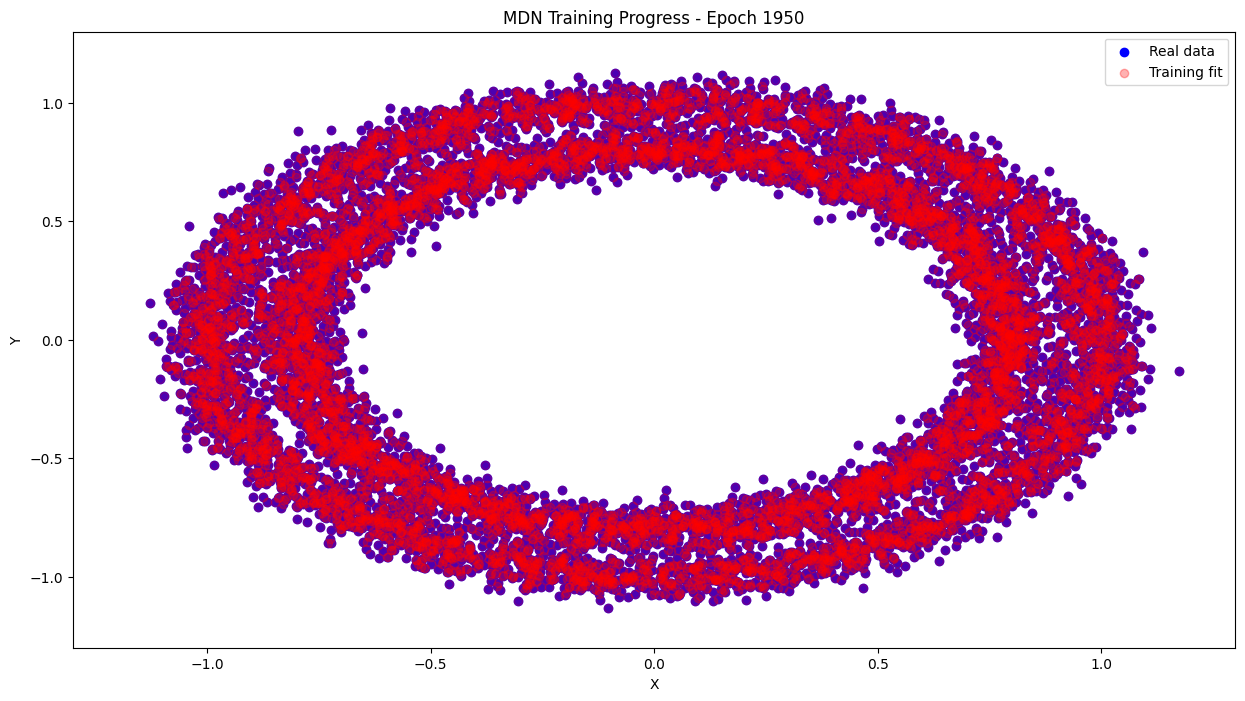

In [734]:
# pi, mu, sigma = training_process(mdn, mdn_loss_robust_univariate, optimizer, 2000, X, Y)
# pi, mu, sigma = training_process(kanmdn, mdn_loss_robust_univariate, optimizer, 2000, X, Y)
X, Y = torch.Tensor(x_circle).to(device), torch.Tensor(y_circle).to(device).reshape(-1,1)
from IPython.display import clear_output

loss_multi_mdn = []

%matplotlib inline
plt.figure(figsize=(10, 6))

for epoch in range(2000):
    ### Training
    mdn.train()
    pi, mu, sigma = mdn(X)
    # print(f"Shape of Y: {Y.shape} | Shape of mu: {mu.shape} | Shape of sigma: {sigma.shape} | Shape of pi: {pi.shape}")
    loss = mdn_loss_3_components(Y, mu, sigma, pi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    mdn.eval()
    with torch.inference_mode():
        pi, mu, sigma = mdn(X)
    

    k = torch.multinomial(pi, 1).view(-1)
    y_pred = torch.normal(mu, sigma)[np.arange(len(Y)), k].data

    loss_multi_mdn.append( loss )
    # Update plot every 50 epochs
    if epoch % 50 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(15, 8))

        # plt.scatter(x_circle[:,0], x_circle[:, 1], c=y_circle)
        plt.scatter(X[:,0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy(), c="blue", label="Real data")
        plt.scatter(X[:,0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy(), c="red", alpha=.3, marker="o" ,label="Training fit")
        plt.legend()
        plt.xlim([-1.3, 1.3])
        plt.ylim([-1.3, 1.3])
        plt.title(f"MDN Training Progress - Epoch {epoch}")
        plt.xlabel("X")
        plt.ylabel("Y")
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")
        plt.pause(0.1)
        plt.show()

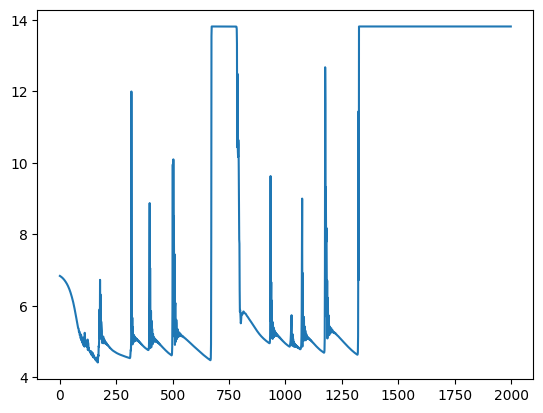

In [744]:
loss_multi_mdn = [val.detach().cpu().numpy() for val in loss_multi_mdn]

plt.plot(np.asarray(loss_multi_mdn))

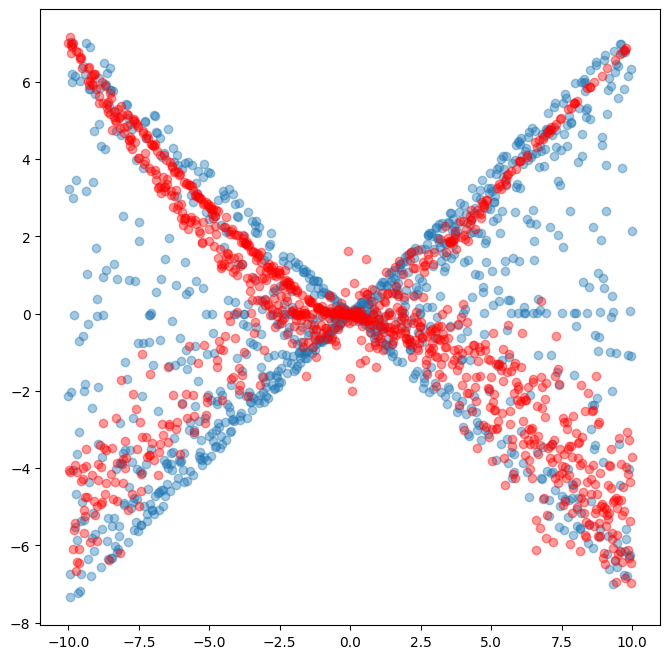

In [618]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(len(Xr)), k].data

plt.figure(figsize=(8, 8))
plt.scatter(X.cpu().numpy(), Y.cpu().numpy(), alpha=0.4, label="Real values")
plt.scatter(X.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")
plt.show()

c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: ylabel='Density'>

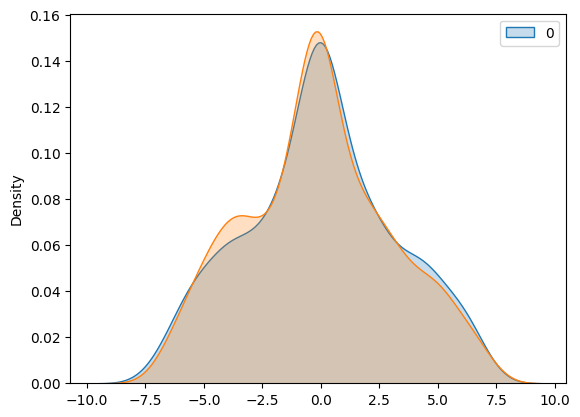

In [622]:
sns.kdeplot(Y.detach().cpu().numpy(), fill=True)
sns.kdeplot(y_pred.detach().cpu().numpy(), fill=True)

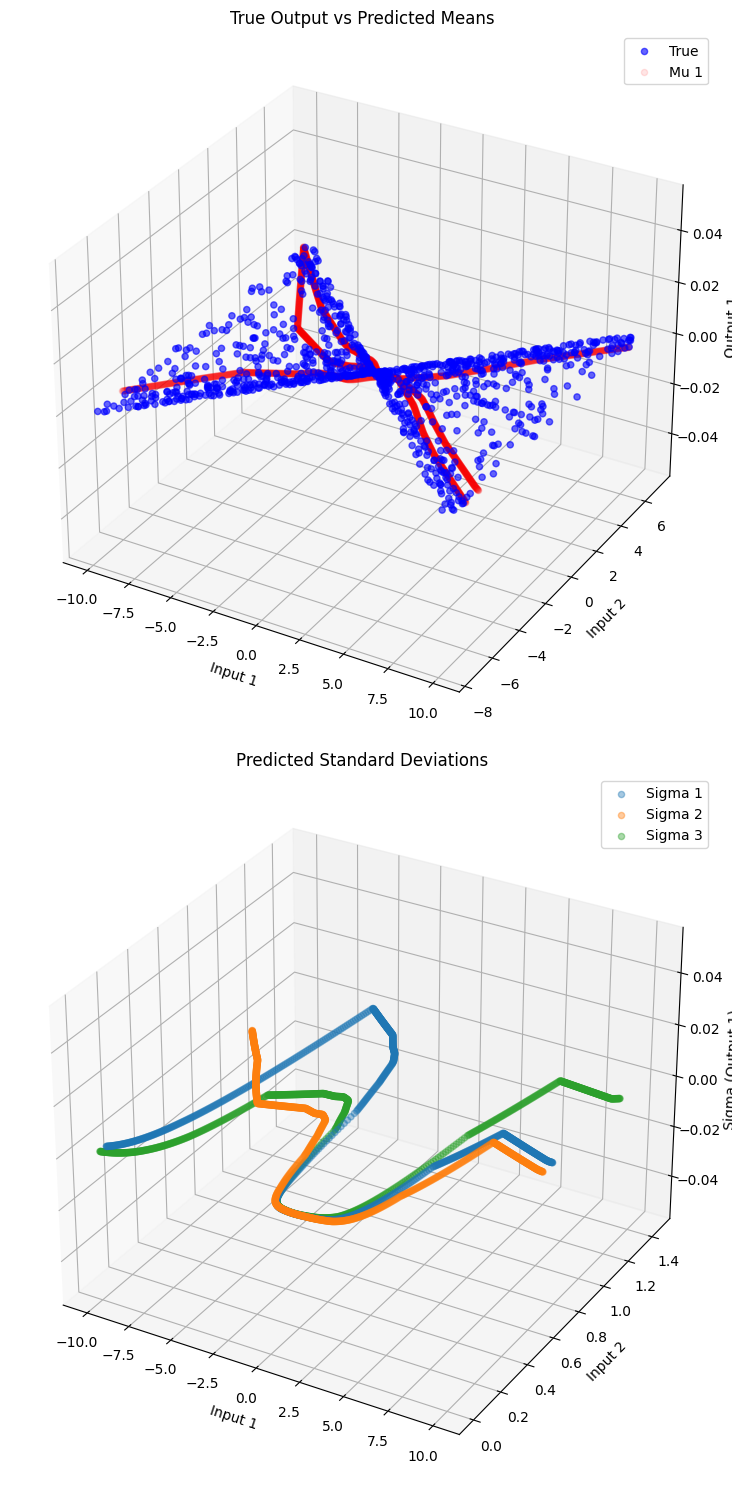

In [431]:
# Create 3D scatter plots
fig = plt.figure(figsize=(20, 15))

# X, Y = X.detach().cpu().numpy(), Y.detach().cpu().numpy()
# pi, mu, sigma = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()

# Plot for the first output dimension
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(X[:, 0], Y[:, :], c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax1.scatter(X[:, 0], mu[:, i], c='r', alpha=0.1, label=f'Mu {i+1}' if i == 0 else "")
ax1.set_xlabel('Input 1')
ax1.set_ylabel('Input 2')
ax1.set_zlabel('Output 1')
ax1.set_title('True Output vs Predicted Means')
ax1.legend()



# Plot sigmas for the first output dimension
ax3 = fig.add_subplot(223, projection='3d')
for i in range(sigma.shape[1]):  # For each mixture component
    ax3.scatter(X[:, 0], sigma[:, i], c=f'C{i}', alpha=0.4, label=f'Sigma {i+1}')
ax3.set_xlabel('Input 1')
ax3.set_ylabel('Input 2')
ax3.set_zlabel('Sigma (Output 1)')
ax3.set_title('Predicted Standard Deviations')
ax3.legend()


plt.tight_layout()
plt.show()



In [657]:
class KANMixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=30, n_mixtures=3, grid_size=5, spline_order=3):
        super().__init__()


        self.hidden_block = nn.Sequential(
            KANLinear(input_dim, hidden_dim, grid_size, spline_order),
            nn.ReLU(),
            KANLinear(hidden_dim, hidden_dim, grid_size, spline_order),
            nn.ReLU()
        )

        self.pi = KANLinear(hidden_dim, n_mixtures, grid_size, spline_order)
        self.mu = KANLinear(hidden_dim, n_mixtures, grid_size, spline_order)
        self.sigma = KANLinear(hidden_dim, n_mixtures, grid_size, spline_order)

    
    def forward(self, x):

        hidden = self.hidden_block(x)

        pi, mu, sigma = F.softmax(self.pi(hidden), 1), self.mu(hidden), F.softplus(self.sigma(hidden))

        return pi, mu, sigma
    
class MultivariateKANMixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_mixtures, n_hidden_layers=2):
        super().__init__()

        layers = [KANLinear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_hidden_layers - 1):
            layers.extend([KANLinear(hidden_dim, hidden_dim), nn.ReLU()])
        self.hidden_block = nn.Sequential(*layers)

        # Output layers
        self.pi = KANLinear(hidden_dim, n_mixtures)
        self.mu = KANLinear(hidden_dim, n_mixtures * output_dim)
        self.sigma = KANLinear(hidden_dim, n_mixtures * output_dim)
        
        self.n_mixtures = n_mixtures
        self.output_dim = output_dim

    def forward(self, x):
        hidden = self.hidden_block(x)
        
        pi = F.softmax(self.pi(hidden), dim=1)
        mu = self.mu(hidden)
        sigma = torch.exp(self.sigma(hidden))
        
        if self.output_dim > 1:
            mu = mu.view(-1, self.n_mixtures, self.output_dim)
            sigma = sigma.view(-1, self.n_mixtures, self.output_dim)
        
        return pi, mu, sigma

In [753]:
# Initialize the model
kanmdn = MultivariateKANMixtureDensityNetwork(2, 30, 3, 5, 3)
kanmdn.to(device)
optimizer = optim.Adam(kanmdn.parameters(), lr=learning_rate, weight_decay=1e-5)

In [754]:


def mdn_loss_3d_output_1d_target(pi, mu, sigma, y):
    """
    Compute the loss for a Mixture Density Network with 3D output and 1D target.
    
    Args:
    - pi: tensor of shape [batch_size, num_mixtures]
    - mu: tensor of shape [batch_size, num_mixtures, 3]
    - sigma: tensor of shape [batch_size, num_mixtures, 3]
    - y: tensor of shape [batch_size, 1]
    
    Returns:
    - loss: scalar tensor - the mean negative log-likelihood
    """
    # Ensure y has the right shape [batch_size, 1, 1]
    y = y.unsqueeze(1)
    # print(f"Y reshaped to: {y.shape}")
    
    # We'll only use the first dimension of mu and sigma
    mu = mu[:, :, 0].unsqueeze(-1).permute(0, 2, 1)  # Shape: [batch_size, num_mixtures, 1]
    sigma = sigma[:, :, 0].unsqueeze(-1).permute(0, 2, 1)  # Shape: [batch_size, num_mixtures, 1]
    
    # Expand y to match mu and sigma shape [batch_size, num_mixtures, 1]
    y = y.expand_as(mu)

    # print(f"Y reshaped to: {y.shape}")
    
    # Compute the normal distribution
    normal = torch.distributions.Normal(mu, sigma)
    
    # Compute log probability
    log_prob = normal.log_prob(y).squeeze(-1)  # Shape: [batch_size, num_mixtures]
    
    # Compute the mixture log probability
    weighted_logprob = log_prob + torch.log(pi + 1e-8)
    
    # Compute the final loss
    loss = -torch.logsumexp(weighted_logprob, dim=1)
    
    return loss.mean()

# Usage:
# loss = mdn_loss_3d_output_1d_target(pi, mu, sigma, Y)

In [755]:
# pi, mu, sigma = training_process(kanmdn, mdn_loss_robust_univariate, optimizer, 2000, X, Y)
X, Y = torch.Tensor(x_circle).to(device), torch.Tensor(y_circle).to(device).reshape(-1,1)
from IPython.display import clear_output

loss_multi_kan = []

%matplotlib inline
plt.figure(figsize=(10, 6))

for epoch in range(2000):
    ### Training
    kanmdn.train()
    pi, mu, sigma = kanmdn(X)
    # print(f"Shape of Y: {Y.shape} | Shape of mu: {mu.shape} | Shape of sigma: {sigma.shape} | Shape of pi: {pi.shape}")
    loss = mdn_loss_3d_output_1d_target(Y, mu, sigma, pi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    kanmdn.eval()
    with torch.inference_mode():
        pi, mu, sigma = kanmdn(X)
    

    k = torch.multinomial(pi, 1).view(-1)
    y_pred = torch.normal(mu, sigma)[np.arange(len(Y)), k].data
    loss_multi_kan.append(loss.detach().cpu().numpy())
    # Update plot every 50 epochs
    if epoch % 10 == 0:
    #     clear_output(wait=True)
    #     plt.figure(figsize=(15, 8))

    #     # plt.scatter(x_circle[:,0], x_circle[:, 1], c=y_circle)
    #     plt.scatter(X[:,0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy(), c="blue", label="Real data")
    #     plt.scatter(X[:,0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy(), c="red", alpha=.3, marker="o" ,label="Training fit")
    #     plt.legend()
    #     plt.xlim([-1.3, 1.3])
    #     plt.ylim([-1.3, 1.3])
    #     plt.title(f"MDN Training Progress - Epoch {epoch}")
    #     plt.xlabel("X")
    #     plt.ylabel("Y")
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")
    #     plt.pause(0.1)
    #     plt.show()

Epoch: 0 | Loss: -7.57635
Epoch: 10 | Loss: -7.62932
Epoch: 20 | Loss: -7.71241
Epoch: 30 | Loss: -7.85140
Epoch: 40 | Loss: -8.08725
Epoch: 50 | Loss: -8.51439
Epoch: 60 | Loss: -9.28398
Epoch: 70 | Loss: -10.48177
Epoch: 80 | Loss: -11.36082
Epoch: 90 | Loss: -11.79861
Epoch: 100 | Loss: -11.88915


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

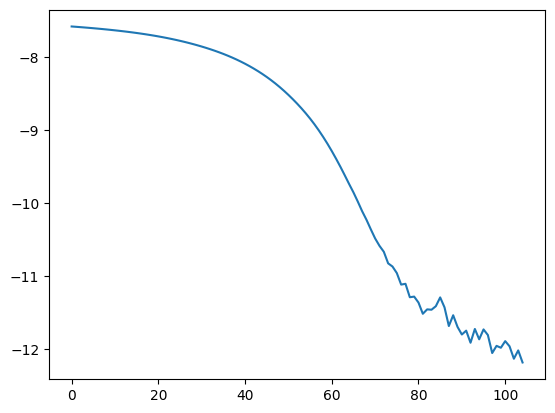

In [757]:
plt.plot(np.asarray(loss_multi_kan))

In [ ]:
    # Update plot every 50 epochs
    if epoch % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))

        # plt.scatter(x_circle[:,0], x_circle[:, 1], c=y_circle)
        plt.scatter(X[:,0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy(), c=Y.detach().cpu().numpy().reshape(-1,), label="Real data")
        plt.scatter(X[:,0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy(), c=y_pred.detach().cpu().numpy().reshape(-1,), label="Training fit")
        plt.legend()
        plt.xlim([-10, 10])
        plt.ylim([-10, 10])
        plt.title(f"MDN Training Progress - Epoch {epoch}")
        plt.xlabel("X")
        plt.ylabel("Y")
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")
        plt.pause(0.1)
        plt.show()

c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jako\anaconda3\envs\imagimob\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

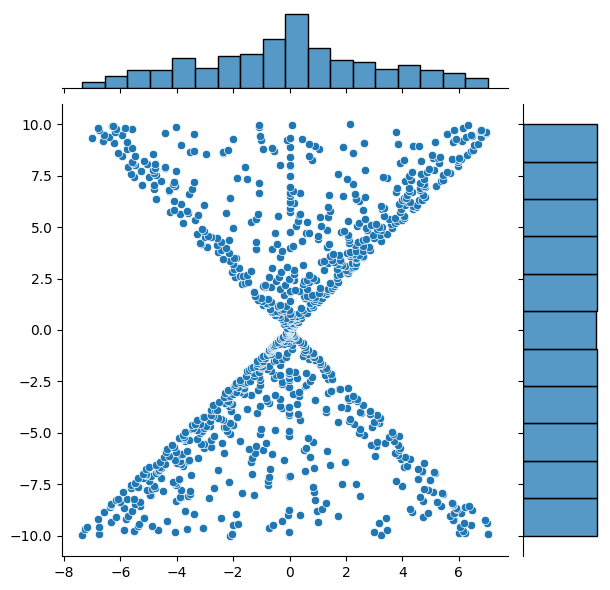

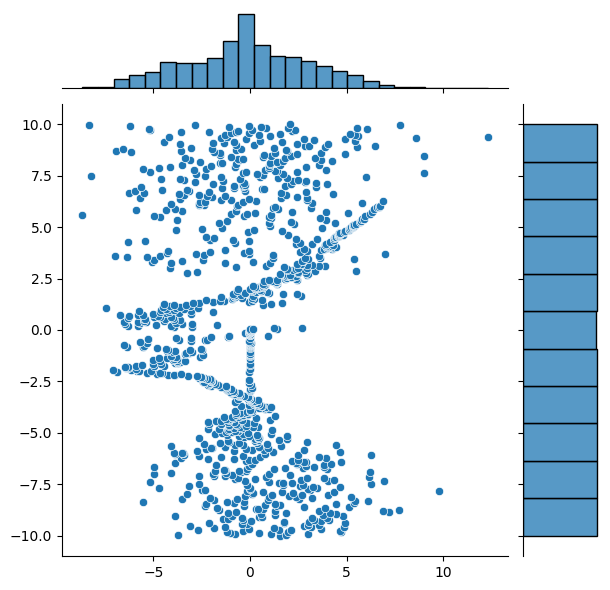

In [646]:
sns.jointplot(x=Y.detach().cpu().numpy().reshape(-1 ,), y=X.detach().cpu().numpy().reshape(-1,))
sns.jointplot(x=y_pred.detach().cpu().numpy().reshape(-1 ,), y=X.detach().cpu().numpy().reshape(-1,))

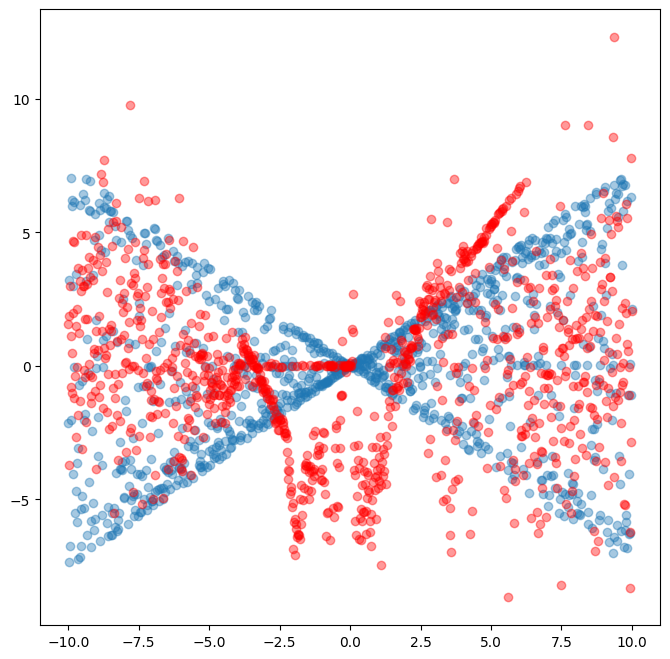

In [639]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(len(Xr)), k].data

plt.figure(figsize=(8, 8))
plt.scatter(X.cpu().numpy(), Y.cpu().numpy(), alpha=0.4, label="Real values")
plt.scatter(X.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")
plt.show()

In [560]:
def create_model(hidden_dim, n_mixtures, grid_size, spline_order):
    return KANMixtureDensityNetwork(
        hidden_dim=hidden_dim, n_mixtures=n_mixtures,
        grid_size=grid_size,
        spline_order=spline_order
    )

In [561]:
from itertools import product

In [586]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, learning_rate, epochs=100, batch_size=32):
    train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = mdn_loss_robust_univariate

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            pi, mu, sigma = model(batch_X)
            loss = criterion(batch_y, mu, sigma, pi)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        pi_val, mu_val, sigma_val = model(X_val)
        val_loss = criterion(y_val, mu_val, sigma_val, pi_val)
    
    return val_loss.item()

In [587]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [588]:
# Define parameter grid

hidden_dims = [30, 64, 128]
n_mixtures = [3, 4, 5]
grid_sizes = [5, 10, 15]
spline_orders = [2, 3, 4]
learning_rates = [0.001, 0.01, 0.1]

In [590]:
for hidden, nmix, grid_size, spline_order, lr in product(hidden_dims, n_mixtures, grid_sizes, spline_orders, learning_rates):
    model = KANMixtureDensityNetwork(input_dim=1, hidden_dim=hidden, n_mixtures=nmix, grid_size=grid_size, spline_order=spline_order)
    model.to(device)
    val_loss = train_and_evaluate(model, X_train.detach().cpu().numpy(), y_train.detach().cpu().numpy(), X_val, y_val, lr)
    results.append( (hidden, nmix, grid_size, spline_order, lr, val_loss) )
    print(f"Hidden dimensions: {hidden} | Number of mixtures: {nmix} | Gridsize: {grid_size} | Spline order: {spline_order} | Learning rate: {lr} | Validation loss: {val_loss}")

Hidden dimensions: 30 | Number of mixtures: 3 | Gridsize: 5 | Spline order: 2 | Learning rate: 0.001 | Validation loss: -1.5875513553619385
Hidden dimensions: 30 | Number of mixtures: 3 | Gridsize: 5 | Spline order: 2 | Learning rate: 0.01 | Validation loss: -1.5859651565551758
Hidden dimensions: 30 | Number of mixtures: 3 | Gridsize: 5 | Spline order: 2 | Learning rate: 0.1 | Validation loss: -1.579698920249939
Hidden dimensions: 30 | Number of mixtures: 3 | Gridsize: 5 | Spline order: 3 | Learning rate: 0.001 | Validation loss: -1.586148738861084
Hidden dimensions: 30 | Number of mixtures: 3 | Gridsize: 5 | Spline order: 3 | Learning rate: 0.01 | Validation loss: -1.5734210014343262
Hidden dimensions: 30 | Number of mixtures: 3 | Gridsize: 5 | Spline order: 3 | Learning rate: 0.1 | Validation loss: nan
Hidden dimensions: 30 | Number of mixtures: 3 | Gridsize: 5 | Spline order: 4 | Learning rate: 0.001 | Validation loss: -1.5882484912872314
Hidden dimensions: 30 | Number of mixtures: 

KeyboardInterrupt: 

In [648]:
class ChebyKANMixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures, degree):
        super().__init__()


        self.hidden_block = nn.Sequential(
            ChebyKANLayer(input_dim, hidden_dim, degree=degree),
            nn.ReLU(),
            ChebyKANLayer(hidden_dim, hidden_dim, degree=degree),
            nn.ReLU()
        )

        self.pi = ChebyKANLayer(hidden_dim, n_mixtures, degree=degree)
        self.mu = ChebyKANLayer(hidden_dim, n_mixtures, degree=degree)
        self.sigma = ChebyKANLayer(hidden_dim, n_mixtures, degree=degree)

    
    def forward(self, x):

        hidden = self.hidden_block(x)

        pi, mu, sigma = F.softmax(self.pi(hidden), 1), self.mu(hidden), F.softplus(self.sigma(hidden))

        return pi, mu, sigma


In [649]:
# Initialize the model
chebymdn = ChebyKANMixtureDensityNetwork(1, 30, 3, 3)
chebymdn.to(device)
optimizer = optim.Adam(chebymdn.parameters(), lr=learning_rate, weight_decay=1e-5)

Epoch: 1990 | Loss: -3.22933


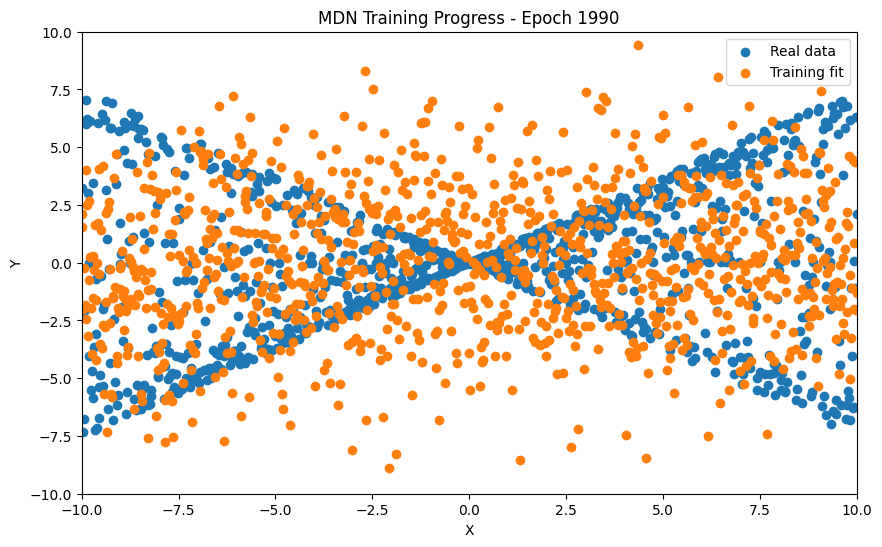

In [650]:
# pi, mu, sigma = training_process(kanmdn, mdn_loss_robust_univariate, optimizer, 2000, X, Y)

from IPython.display import clear_output

%matplotlib inline
plt.figure(figsize=(10, 6))

for epoch in range(2000):
    ### Training
    chebymdn.train()
    pi, mu, sigma = chebymdn(X)
    loss = mdn_loss_robust_univariate(Y, mu, sigma, pi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    chebymdn.eval()
    with torch.inference_mode():
        pi, mu, sigma = chebymdn(X)
    

    k = torch.multinomial(pi, 1).view(-1)
    y_pred = torch.normal(mu, sigma)[np.arange(len(Xr)), k].data
    # Update plot every 50 epochs
    if epoch % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.scatter(X.detach().cpu().numpy(), Y.detach().cpu().numpy(), label="Real data")
        plt.scatter(X.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), label="Training fit")
        plt.legend()
        plt.xlim([-10, 10])
        plt.ylim([-10, 10])
        plt.title(f"MDN Training Progress - Epoch {epoch}")
        plt.xlabel("X")
        plt.ylabel("Y")
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")
        plt.pause(0.1)
        plt.show()